In [2]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import cv2
%matplotlib inline

## Распознавание кружочка на изображении

План работы:
* Загружаем изображение
* Скалируем его, чтобы изображение не было слишком большим
* Применяем фильтр Canny для выделения границ в изображении
* Строим матрицу расстояний от граничных пикселей до всех остальных
* Проверяем, попадает ли большая часть целевых пикселей на окружность определенного радиуса
* Запоминаем пиксели которые хорошо ложатся на окружность
* отрисовываем найденные окружности


Предполагаемый центр окружности будет равноудален от всех точек на ее границе. Построив матрицу расстояний, мы сможем обнаружить, какие точки лежат на разных расстояниях от данной. Потом мы от этой точки с дискретным шагом будем "строить" окружности и смотреть, насколько много точек попадает на эти предполагаемые окружности. Если число точек будет достаточно большим, то точка, на которой мы находимся, будет сохранена вместе со значением радиуса найденной окружности.
После этого окружности отрисуем на графике

### Загрузка и скалирование изображения

In [10]:
PATH = '/home/asha/ИБ/python/Images/circle.png'
RAD_STEP = 5  # шаг увеличения радиуса
RAD_DELTA = 3  # порог отсечения точек, которые слишком далеко от значения радиуса (эмпирически)
LOWEST_RAD = 10  # минимальный (стартовый) радиус поиска окружности 
THRESHOLD = 0.4  # Порог близости количества точек к предполагаемому для каждого радиуса (эмпирически)

img = cv2.imread(PATH)

@dataclass  # понадобится для запоминания будущего центра окружности и ее отрисовки
class Circle():
    x_center: int
    y_center: int
    radius: int

        
# Скалируем изображение для ускорения алгоритма

if max(img.shape) > 256:
    proportion = max(img.shape[0] // 256, img.shape[1] // 256)
    scaled_img = cv2.resize(img, dsize=(img.shape[1] // proportion, img.shape[0] // proportion))
else:
    scaled_img = img

(-0.5, 299.5, 299.5, -0.5)

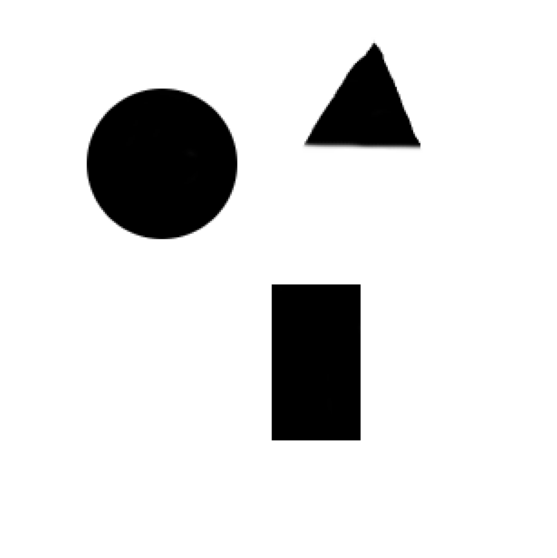

In [11]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.imshow(scaled_img)
plt.axis('off')

### Применение фильтра Canny для выделения границ в изображении

In [12]:
edged_img = cv2.Canny(scaled_img, 10, 100) // 255
edges = np.argwhere(edged_img == 1)  # Координаты граничных пикселей

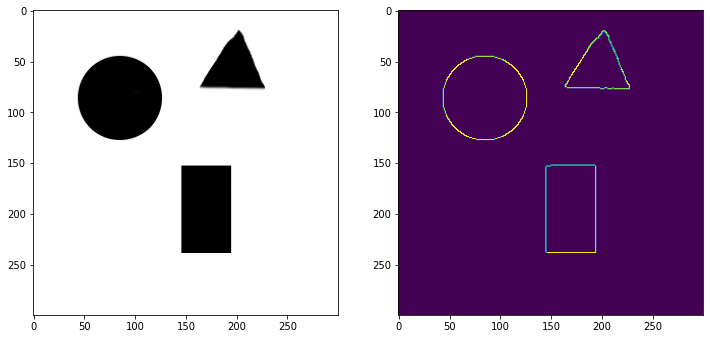

In [13]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(scaled_img)
axs[1].imshow(edged_img)

### Строим матрицу расстояний от граничных пикселей до всех остальных

In [14]:
def dif(a, b):
    a_new = a[..., np.newaxis]
    b_new = b[np.newaxis, ...]
    return a_new - b_new
# meshgrid выводит два массива с x и y координатами всех пикселей
x, y = np.meshgrid(np.arange(edged_img.shape[0]), np.arange(edged_img.shape[1]))
x = x.ravel()
y = y.ravel()
# считаем матрицу расстояний от каждого целевого до всех остальных пикселей
dist_to_all = np.sqrt((dif(edges[:, 0], x) ** 2 + dif(edges[:, 1], y) ** 2).squeeze())
dist_to_all.shape  #794 граничных пикселя и 90000 значений расстояний для каждого 

(794, 90000)

### Запускаем алгоритм

In [15]:
MAX_RADIUS = int(0.5 * min(edged_img.shape)) # окружность бОльшего радиуса не поместится целиком на изображение

possible_rads = np.array(range(LOWEST_RAD, MAX_RADIUS + RAD_STEP, RAD_STEP))  # все радиусы которые переберем


circles = []
for col in tqdm(range(dist_to_all.shape[1])):
    for rad in possible_rads:
        # сравниваем расстояние от точки до граничного пикселя с радиусом и затем с заданной константой
        cands_for_circle = np.argwhere(np.abs(dist_to_all[:, col] - rad) < RAD_DELTA).ravel()
        if len(cands_for_circle) > 0:
            # На границе должно быть примерно 4 * pi * R точек (pi * (r + 1)^2 - pi * (r - 1)^2)
            circleness = abs(1 - (len(cands_for_circle) / (4 * np.pi * rad)))
            # запоминаем параметры будущей окружности если она примерно удовлетворяет порогу
            if circleness < THRESHOLD:
                circle = Circle(x_center = x[col],
                                y_center = y[col],
                                radius = rad)
                circles.append(circle)
# создаем круги на основе полученного списка
circles_mask = np.zeros_like(edged_img)
for circle in circles:
    cv2.circle(img=circles_mask,
               center=(circle.y_center, circle.x_center),
               radius=circle.radius,
               color=(255, 255, 255),
               thickness=1)

  0%|          | 0/90000 [00:00<?, ?it/s]

### Отрисовываем картинку и найденную окружность

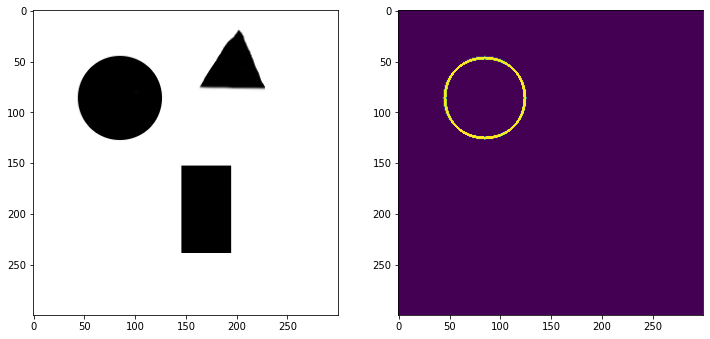

In [17]:
circles_mask = cv2.resize(circles_mask, dsize=(img.shape[1], img.shape[0]))
fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(img)
axs[1].imshow(circles_mask)

Алгоритм работает медленнее, если граничных пикселей очень много. Можно регулировать значения RAD_STEP, RAD_DELTA, LOWEST_RAD и THRESHOLD чтобы добиться более точного поиска окружностей на картинке